# Lab 1: Time Series Analysis - BTC Hourly Data

This notebook performs the tasks outlined in Lab 1:
1.  **Select Dataset**: Fetches the last 5000 hourly OHLCV (Open, High, Low, Close, Volume) data points for BTCUSDT from Binance. The fetched data is then saved to a CSV file in a `data` directory relative to the project root.
2.  **Plot Time Series**: Graphically displays the fetched time series data. Plots are saved in `PROJECT_ROOT/results/lab_1/`.
3.  **Preprocessing**:
    * Checks for missing data.
    * Applies a simple moving average filter to the 'Close' price.
    * Discusses and demonstrates attribute reduction.

In [2]:
# Cell 1: Imports and Setup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import requests
import time
from datetime import datetime, timezone, timedelta
import logging
import os

# Setup basic logging for the script
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style

# --- Path Definitions ---
_NOTEBOOK_CURRENT_DIR = os.getcwd() # This is PROJECT_ROOT/notebooks/
PROJECT_ROOT = os.path.abspath(os.path.join(_NOTEBOOK_CURRENT_DIR, '..'))
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
PLOT_SAVE_DIR = os.path.join(RESULTS_DIR, 'lab_1')

# Create DATA_DIR if it doesn't exist
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    logging.info(f"Created data directory: {DATA_DIR}")

# Create PLOT_SAVE_DIR if it doesn't exist
if not os.path.exists(PLOT_SAVE_DIR):
    os.makedirs(PLOT_SAVE_DIR)
    logging.info(f"Created plot save directory: {PLOT_SAVE_DIR}")

logging.info(f"Project Root assumed: {PROJECT_ROOT}")
logging.info(f"Data directory set to: {DATA_DIR}")
logging.info(f"Results directory set to: {RESULTS_DIR}")
logging.info(f"Plot save directory for Lab 1 set to: {PLOT_SAVE_DIR}")

2025-05-14 11:54:31,165 - INFO - Created data directory: /home/denis/kpi/tsp/data
2025-05-14 11:54:31,166 - INFO - Created plot save directory: /home/denis/kpi/tsp/results/lab_1
2025-05-14 11:54:31,166 - INFO - Project Root assumed: /home/denis/kpi/tsp
2025-05-14 11:54:31,167 - INFO - Data directory set to: /home/denis/kpi/tsp/data
2025-05-14 11:54:31,167 - INFO - Results directory set to: /home/denis/kpi/tsp/results
2025-05-14 11:54:31,167 - INFO - Plot save directory for Lab 1 set to: /home/denis/kpi/tsp/results/lab_1


## Task 1: Select Dataset

We will fetch the last 5000 hourly OHLCV data points for the BTCUSDT trading pair directly from the Binance API.
The fetched data will be saved to a CSV file in the `PROJECT_ROOT/data/` directory.

In [3]:
# Cell 2: Helper functions for Binance API interaction

# Binance API constants
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"
MAX_KLINE_LIMIT = 1000  # Max klines per request from Binance
REQUEST_TIMEOUT = 15    # Seconds
MAX_RETRIES = 3         # Max retries for a single chunk request
RETRY_DELAY = 5         # Seconds between retries

def _ms_to_datetime_utc(ms):
    """Converts milliseconds timestamp to timezone-aware UTC datetime object."""
    return datetime.fromtimestamp(ms / 1000, tz=timezone.utc)

def _datetime_to_ms_utc(dt):
    """Converts datetime object to milliseconds timestamp."""
    return int(dt.timestamp() * 1000)

def fetch_binance_klines_from_api(symbol, interval, limit=500, end_time_dt=None):
    """
    Fetches klines (candlestick data) directly from Binance API.
    To get the *last* N klines, we work backwards from the current time or a specified end_time.

    Args:
        symbol (str): Trading pair (e.g., 'BTCUSDT').
        interval (str): Kline interval (e.g., '1h', '4h', '1d').
        limit (int): Number of klines to fetch.
        end_time_dt (datetime, optional): If specified, fetch klines ending before this time.
                                          Defaults to current UTC time.

    Returns:
        pd.DataFrame: DataFrame with OHLCV data, or empty DataFrame on failure.
    """
    all_klines_data = []
    records_to_fetch = limit
    # current_end_time_ms will be the 'endTime' for the API call in the first iteration.
    # For subsequent iterations, it's the open time of the first kline of the previously fetched chunk.
    current_end_time_ms = _datetime_to_ms_utc(end_time_dt) if end_time_dt else _datetime_to_ms_utc(datetime.now(timezone.utc))


    while records_to_fetch > 0:
        current_limit = min(records_to_fetch, MAX_KLINE_LIMIT)
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': current_limit,
            # For the first request, endTime is now. For subsequent requests, it's the start of the previous batch.
            # Binance 'endTime' is inclusive. We want klines *before* this time.
            'endTime': current_end_time_ms
        }

        logging.info(f"Fetching {current_limit} klines for {symbol} ending at or before {pd.to_datetime(params.get('endTime'), unit='ms', utc=True)}")

        for attempt in range(MAX_RETRIES):
            try:
                response = requests.get(BINANCE_API_URL, params=params, timeout=REQUEST_TIMEOUT)
                response.raise_for_status()
                klines_chunk = response.json()

                if not klines_chunk:
                    logging.info(f"API returned no more data for {symbol} with endTime {current_end_time_ms}.")
                    records_to_fetch = 0 # Stop fetching if API returns empty list
                    break

                # API returns in ascending order; we prepend to build descending then reverse later,
                # or sort by 'Open time' after converting to DataFrame.
                # For fetching backwards, each new chunk is older, so prepend it.
                all_klines_data = klines_chunk + all_klines_data
                records_to_fetch -= len(klines_chunk)

                # For the next older batch, the new 'endTime' should be just before the open time of the first kline we just got.
                # klines_chunk[0][0] is the open time of the earliest kline in this chunk.
                current_end_time_ms = klines_chunk[0][0] - 1 # Subtract 1ms to avoid overlap

                break # Success for this chunk

            except requests.exceptions.Timeout:
                logging.warning(f"Timeout fetching {symbol}. Attempt {attempt+1}/{MAX_RETRIES}. Retrying in {RETRY_DELAY}s...")
            except requests.exceptions.RequestException as e:
                status_code = e.response.status_code if e.response is not None else None
                if status_code in [429, 418]: # Rate limit
                    rate_limit_delay = RETRY_DELAY * (attempt + 2)
                    logging.warning(f"Rate limit (Status: {status_code}) for {symbol}. Attempt {attempt+1}/{MAX_RETRIES}. Retrying after {rate_limit_delay}s...")
                    time.sleep(rate_limit_delay)
                    # continue will go to the next attempt of the for loop
                else:
                    logging.warning(f"Request failed for {symbol}: {e}. Status: {status_code}. Attempt {attempt+1}/{MAX_RETRIES}. Retrying...")
            except Exception as e:
                logging.error(f"Unexpected error fetching {symbol}: {e}", exc_info=True)
                # Return what we have so far, or an empty DataFrame if this was the first chunk
                df_partial = pd.DataFrame()
                if all_klines_data:
                     columns_temp = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
                     df_partial = pd.DataFrame(all_klines_data, columns=columns_temp)
                return df_partial


            if attempt < MAX_RETRIES - 1:
                time.sleep(RETRY_DELAY)
            else:
                logging.error(f"Failed to fetch data chunk for {symbol} after {MAX_RETRIES} attempts.")
                 # Return what we have so far, even if incomplete
                df_partial_fail = pd.DataFrame()
                if all_klines_data:
                     columns_temp_fail = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
                     df_partial_fail = pd.DataFrame(all_klines_data, columns=columns_temp_fail)
                return df_partial_fail


        if not klines_chunk and records_to_fetch > 0:
            logging.warning(f"API returned no more data for {symbol}, but {records_to_fetch} records were still expected.")
            break


    if not all_klines_data:
        logging.warning(f"No klines fetched for {symbol}.")
        return pd.DataFrame()

    # Define column names for Binance kline data
    columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
               'Close time', 'Quote asset volume', 'Number of trades',
               'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    df = pd.DataFrame(all_klines_data, columns=columns)

    # Select and format necessary columns
    df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', utc=True)
    df.set_index('Open time', inplace=True)
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Ensure data is sorted by time (it should be due to prepending)
    df.sort_index(inplace=True)
    df = df[~df.index.duplicated(keep='first')] # Should not be necessary if logic is correct

    # Return only the last 'limit' records requested originally
    return df.tail(limit)

In [4]:
# Cell 3: Fetching the last 5000 hourly BTCUSDT data points and saving
SYMBOL = 'BTCUSDT'
INTERVAL = '1h'
DATA_POINTS_TO_FETCH = 5000

logging.info(f"Fetching last {DATA_POINTS_TO_FETCH} hourly data points for {SYMBOL} from API...")
btc_df = fetch_binance_klines_from_api(SYMBOL, INTERVAL, limit=DATA_POINTS_TO_FETCH)

if not btc_df.empty and len(btc_df) == DATA_POINTS_TO_FETCH:
    logging.info(f"Successfully fetched {len(btc_df)} BTCUSDT data points. Shape: {btc_df.shape}")
    print("Sample of the data (first 5 rows):")
    print(btc_df.head())

    # Save the fetched data
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{SYMBOL.lower()}_hourly_last{DATA_POINTS_TO_FETCH}_{timestamp_str}.csv"
    filepath = os.path.join(DATA_DIR, filename)
    try:
        btc_df.to_csv(filepath)
        logging.info(f"Data saved to: {filepath}")
    except Exception as e:
        logging.error(f"Failed to save data to CSV: {e}")
elif not btc_df.empty:
    logging.warning(f"Fetched {len(btc_df)} data points, but expected {DATA_POINTS_TO_FETCH}. Using what was fetched.")
    print(f"Fetched {len(btc_df)} data points, but expected {DATA_POINTS_TO_FETCH}.")
    print(btc_df.head())
    # Optionally save this partial data too
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{SYMBOL.lower()}_hourly_partial_last{len(btc_df)}_{timestamp_str}.csv"
    filepath = os.path.join(DATA_DIR, filename)
    try:
        btc_df.to_csv(filepath)
        logging.info(f"Partial data saved to: {filepath}")
    except Exception as e:
        logging.error(f"Failed to save partial data to CSV: {e}")
else:
    logging.error(f"Failed to fetch sufficient data for {SYMBOL}.")
    # Create an empty DataFrame with expected columns if fetch fails
    btc_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

2025-05-14 11:58:34,853 - INFO - Fetching last 5000 hourly data points for BTCUSDT from API...
2025-05-14 11:58:34,858 - INFO - Fetching 1000 klines for BTCUSDT ending at or before 2025-05-14 08:58:34.854000+00:00
2025-05-14 11:58:35,204 - INFO - Fetching 1000 klines for BTCUSDT ending at or before 2025-04-02 16:59:59.999000+00:00
2025-05-14 11:58:35,549 - INFO - Fetching 1000 klines for BTCUSDT ending at or before 2025-02-20 00:59:59.999000+00:00
2025-05-14 11:58:35,883 - INFO - Fetching 1000 klines for BTCUSDT ending at or before 2025-01-09 08:59:59.999000+00:00
2025-05-14 11:58:36,430 - INFO - Fetching 1000 klines for BTCUSDT ending at or before 2024-11-28 16:59:59.999000+00:00
2025-05-14 11:58:36,789 - INFO - Successfully fetched 5000 BTCUSDT data points. Shape: (5000, 5)
2025-05-14 11:58:36,819 - INFO - Data saved to: /home/denis/kpi/tsp/data/btcusdt_hourly_last5000_20250514_115836.csv


Sample of the data (first 5 rows):
                               Open      High      Low     Close      Volume
Open time                                                                   
2024-10-18 01:00:00+00:00  67214.41  68260.92  67194.0  68085.50  2138.13847
2024-10-18 02:00:00+00:00  68085.50  68142.00  67800.0  68103.99  1073.14990
2024-10-18 03:00:00+00:00  68104.00  68108.58  67522.0  67555.40   978.29799
2024-10-18 04:00:00+00:00  67555.41  67867.93  67544.0  67742.72   770.77181
2024-10-18 05:00:00+00:00  67742.71  68050.00  67640.0  68000.79   567.44614


## Task 2: Plot Time Series

Now, we'll visualize the Open, High, Low, Close, and Volume data for BTCUSDT.
The plot will be saved in `PROJECT_ROOT/results/lab_1/`.

2025-05-14 11:59:43,702 - INFO - OHLCV plot saved as /home/denis/kpi/tsp/results/lab_1/lab1_plot_btcusdt_ohlcv.png


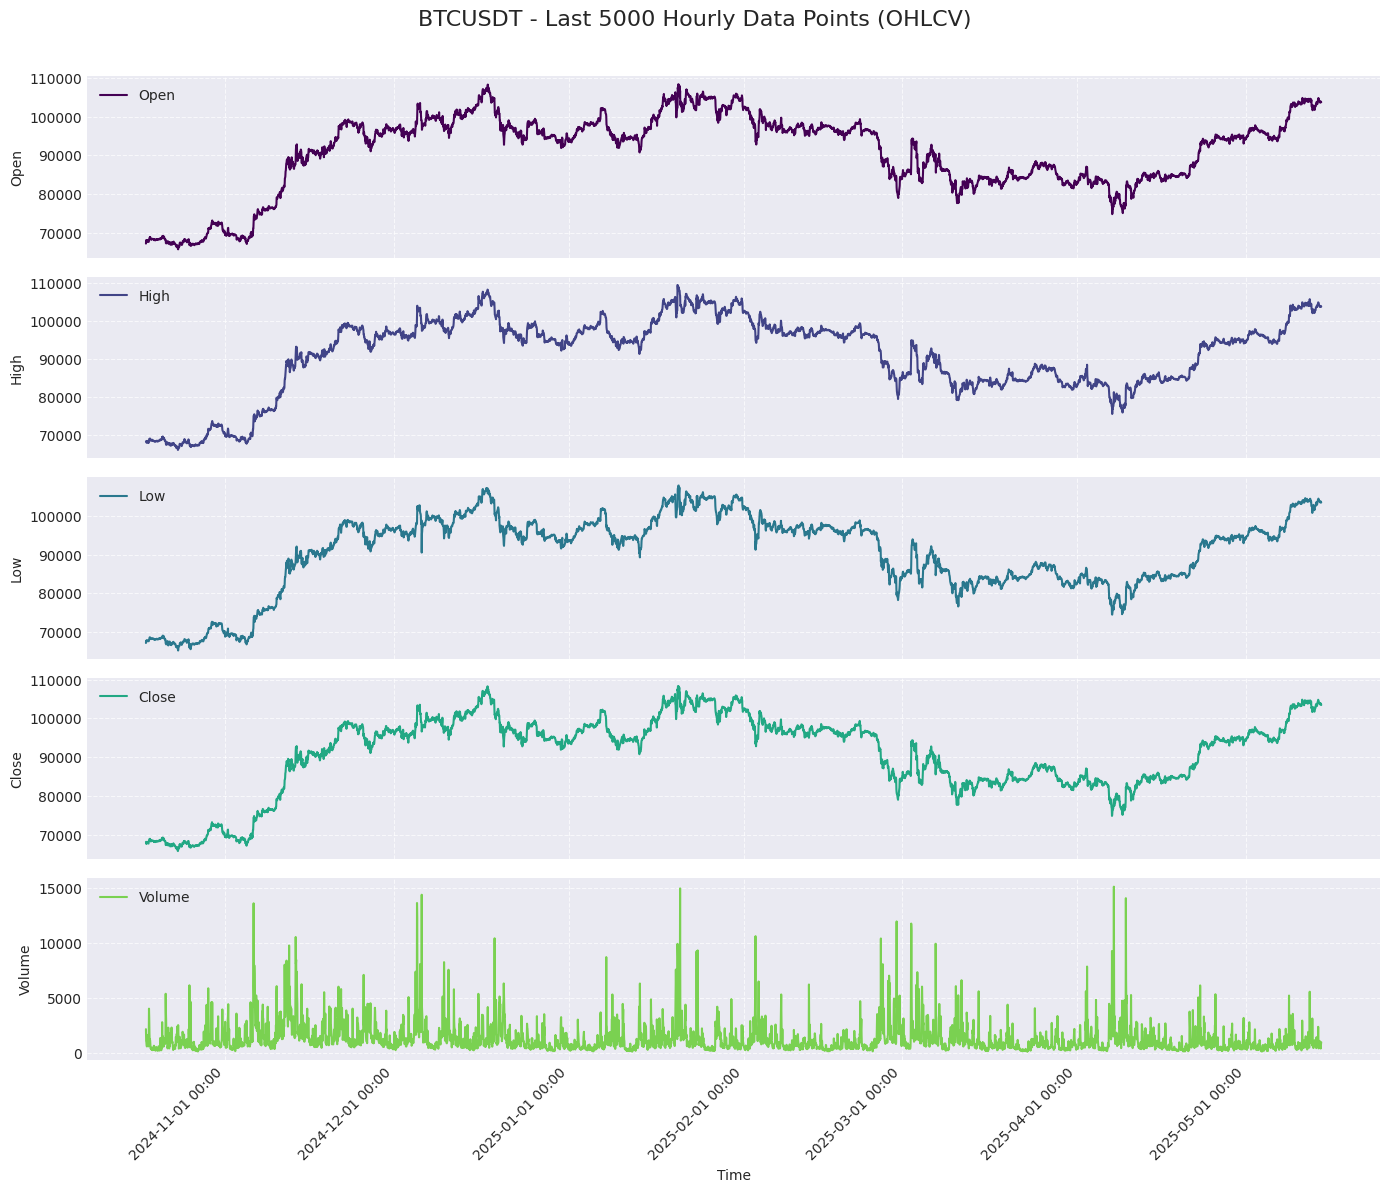

In [5]:
# Cell 4: Plotting the OHLCV data

if not btc_df.empty:
    num_features_to_plot = len(btc_df.columns)
    fig, axes = plt.subplots(num_features_to_plot, 1, figsize=(14, num_features_to_plot * 2.5), sharex=True) # Adjusted height
    if num_features_to_plot == 1:
        axes = [axes]

    for i, column in enumerate(btc_df.columns):
        axes[i].plot(btc_df.index, btc_df[column], label=column, color=plt.cm.viridis(i / num_features_to_plot))
        axes[i].set_ylabel(column)
        axes[i].legend(loc='upper left')
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        axes[i].grid(True, linestyle='--', alpha=0.7)

    plt.suptitle(f"{SYMBOL} - Last {len(btc_df)} Hourly Data Points (OHLCV)", fontsize=16)
    plt.xlabel("Time")
    fig.autofmt_xdate(rotation=45) # Apply auto-rotation for x-axis labels
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make space for suptitle

    # Save the plot to PLOT_SAVE_DIR
    plot_filename = f"lab1_plot_{SYMBOL.lower()}_ohlcv.png"
    plot_filepath = os.path.join(PLOT_SAVE_DIR, plot_filename) # Use PLOT_SAVE_DIR
    try:
        plt.savefig(plot_filepath)
        logging.info(f"OHLCV plot saved as {plot_filepath}")
    except Exception as e:
        logging.error(f"Could not save OHLCV plot: {e}")
    plt.show()
else:
    logging.warning("btc_df is empty. Skipping Task 2 plotting.")

## Task 3: Preprocessing Time Series

This section covers:
* Checking for missing data.
* Filtering the data using a Simple Moving Average (SMA).
* Reducing attributes.

### 3a. Check for Missing Data

In [6]:
# Cell 5: Checking for missing data
if not btc_df.empty:
    logging.info("--- Checking for Missing Data ---")
    missing_values = btc_df.isnull().sum()
    total_missing = missing_values.sum()
    if total_missing > 0:
        logging.warning(f"Missing values found in the BTC data points:\n{missing_values[missing_values > 0]}")
        print(f"Missing values found:\n{missing_values[missing_values > 0]}")
        # btc_df.ffill(inplace=True) # Example: Forward fill
        # logging.info("Applied forward-fill to handle NaNs. Re-check if needed.")
    else:
        logging.info("No missing values found in the selected BTC data points.")
        print("No missing values found.")
else:
    logging.warning("btc_df is empty. Skipping missing data check.")

2025-05-14 12:01:13,485 - INFO - --- Checking for Missing Data ---
2025-05-14 12:01:13,486 - INFO - No missing values found in the selected BTC data points.


No missing values found.


### 3b. Filter Data

We'll apply a 7-hour Simple Moving Average (SMA) to the 'Close' price as an example of filtering.
The plot will be saved in `PROJECT_ROOT/results/lab_1/`.

2025-05-14 12:02:19,005 - INFO - --- Filtering Data (Moving Average on Close Price) ---
2025-05-14 12:02:19,125 - INFO - SMA plot saved as /home/denis/kpi/tsp/results/lab_1/lab1_plot_btcusdt_close_sma.png


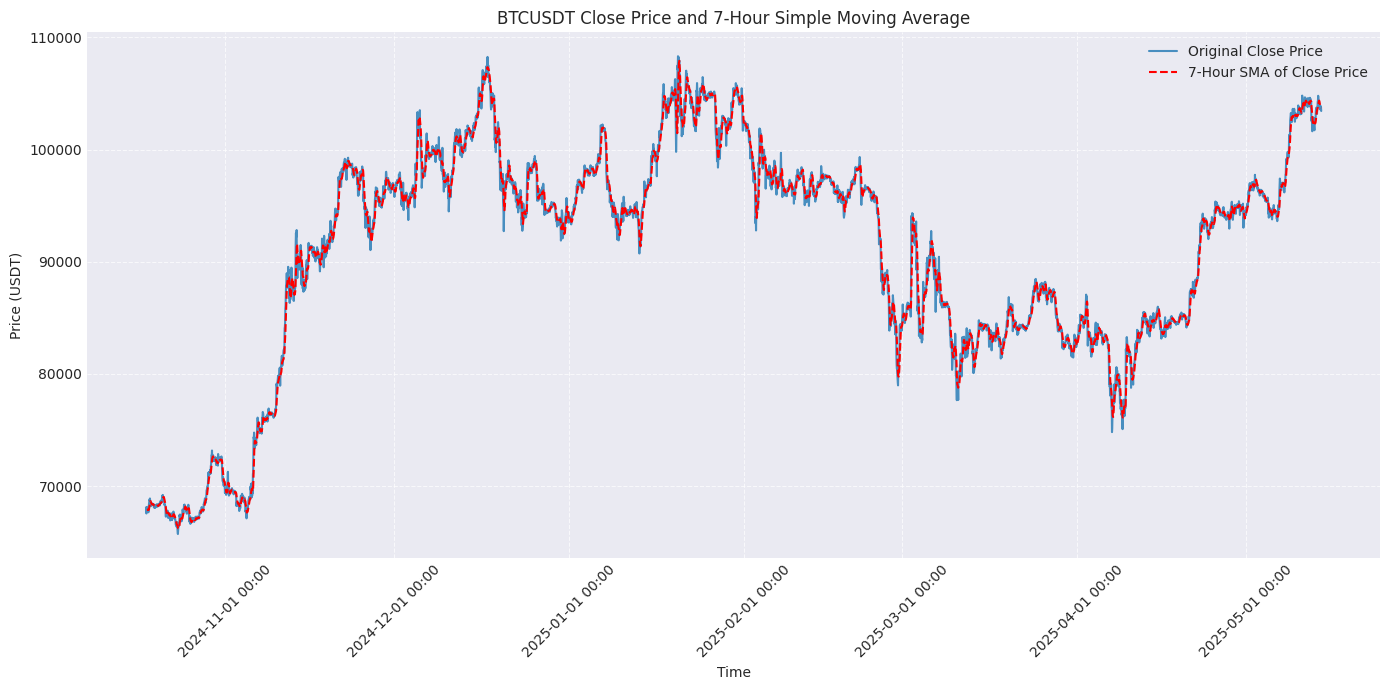

In [7]:
# Cell 6: Filtering data (Simple Moving Average on 'Close' price)
if not btc_df.empty and 'Close' in btc_df.columns:
    logging.info("--- Filtering Data (Moving Average on Close Price) ---")
    window_size_ma = 7
    # Ensure 'Close' is numeric before rolling, handle potential earlier coerce issues
    if pd.api.types.is_numeric_dtype(btc_df['Close']):
        btc_df['Close_SMA_7'] = btc_df['Close'].rolling(window=window_size_ma).mean()

        plt.figure(figsize=(14, 7))
        plt.plot(btc_df.index, btc_df['Close'], label='Original Close Price', alpha=0.8)
        if 'Close_SMA_7' in btc_df: # Check if SMA column was successfully created
             plt.plot(btc_df.index, btc_df['Close_SMA_7'], label=f'{window_size_ma}-Hour SMA of Close Price', linestyle='--', color='red')
        plt.title(f'{SYMBOL} Close Price and {window_size_ma}-Hour Simple Moving Average')
        plt.xlabel('Time')
        plt.ylabel('Price (USDT)')
        plt.legend()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Save the plot to PLOT_SAVE_DIR
        sma_plot_filename = f"lab1_plot_{SYMBOL.lower()}_close_sma.png"
        sma_plot_filepath = os.path.join(PLOT_SAVE_DIR, sma_plot_filename) # Use PLOT_SAVE_DIR
        try:
            plt.savefig(sma_plot_filepath)
            logging.info(f"SMA plot saved as {sma_plot_filepath}")
        except Exception as e:
            logging.error(f"Could not save SMA plot: {e}")
        plt.show()
    else:
        logging.warning("'Close' column is not numeric or SMA calculation failed. Skipping SMA plot.")
elif 'Close' not in btc_df.columns:
    logging.warning("'Close' column not found. Skipping SMA filtering example.")
else: # btc_df is empty
    logging.warning("btc_df is empty. Skipping SMA filtering example.")

### 3c. Reduce Attributes

The current dataset (OHLCV) is multivariate. We can reduce attributes by selecting a subset of features. For example, focusing only on the 'Close' price for a univariate analysis.

In [8]:
# Cell 7: Reducing attributes
if not btc_df.empty:
    logging.info("--- Reducing Attributes ---")
    # Use .columns before potential modification by SMA
    current_attributes = [col for col in btc_df.columns if col != 'Close_SMA_7'] # Exclude added SMA for this count
    logging.info(f"The BTC dataset (excluding added SMA) has {len(current_attributes)} attributes: {current_attributes}")
    logging.info("This is a multivariate time series.")

    if 'Close' in btc_df.columns:
        btc_close_univariate = btc_df[['Close']].copy() # Create a new DataFrame with only 'Close'
        logging.info(f"Reduced to univariate 'Close' price. Shape: {btc_close_univariate.shape}")
        print(f"\nOriginal attributes (excluding SMA): {current_attributes}")
        print(f"Attributes after reduction (selecting 'Close' only): {btc_close_univariate.columns.tolist()}")
        print("Sample of univariate 'Close' data:")
        print(btc_close_univariate.head())
    else:
        logging.warning("'Close' column not found, cannot demonstrate reduction to 'Close' price.")

    logging.info("Further attribute reduction could involve techniques like Principal Component Analysis (PCA) or feature selection based on importance for specific modeling tasks.")
    logging.info("For this lab, selecting the 'Close' price column demonstrates a basic form of attribute reduction.")
else:
    logging.warning("btc_df is empty. Skipping attribute reduction.")

2025-05-14 12:13:56,778 - INFO - --- Reducing Attributes ---
2025-05-14 12:13:56,778 - INFO - The BTC dataset (excluding added SMA) has 5 attributes: ['Open', 'High', 'Low', 'Close', 'Volume']
2025-05-14 12:13:56,779 - INFO - This is a multivariate time series.
2025-05-14 12:13:56,780 - INFO - Reduced to univariate 'Close' price. Shape: (5000, 1)
2025-05-14 12:13:56,781 - INFO - Further attribute reduction could involve techniques like Principal Component Analysis (PCA) or feature selection based on importance for specific modeling tasks.
2025-05-14 12:13:56,781 - INFO - For this lab, selecting the 'Close' price column demonstrates a basic form of attribute reduction.



Original attributes (excluding SMA): ['Open', 'High', 'Low', 'Close', 'Volume']
Attributes after reduction (selecting 'Close' only): ['Close']
Sample of univariate 'Close' data:
                              Close
Open time                          
2024-10-18 01:00:00+00:00  68085.50
2024-10-18 02:00:00+00:00  68103.99
2024-10-18 03:00:00+00:00  67555.40
2024-10-18 04:00:00+00:00  67742.72
2024-10-18 05:00:00+00:00  68000.79


---
## Lab Conclusion

This notebook successfully performed the required tasks:
1.  Fetched the last 5000 hourly BTCUSDT OHLCV data points and saved a copy to the `data` directory.
2.  Plotted these multivariate time series and saved the plot to `PROJECT_ROOT/results/lab_1/`.
3.  Conducted preprocessing including:
    * Checking for missing values.
    * Applying a Simple Moving Average filter and saving the plot to `PROJECT_ROOT/results/lab_1/`.
    * Demonstrating attribute reduction by selecting the 'Close' price.
---